In [1]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
  stacklevel=1)


Using device: cuda

GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
from collections import Counter
import ipywidgets as widgets
import json
import csv
import pandas as pd
from urllib.request import urlopen


In [3]:
# Extract projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects)} projects")
projects.head()


955 projects


,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [4]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects_tags)} projects")
projects_tags.head()

955 projects


,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [5]:
df = pd.concat([projects, projects_tags], axis=1)
df = df.T.drop_duplicates().T
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [6]:
# Remove projects with no tag
df = df[df.tag.notnull()]

In [7]:
df.to_csv("labeled_projects.csv", index=False)

In [8]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [9]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags_dict = {}
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation
for item in projects_tags.tag:
    tags_dict[item] = item

print (f"{len(tags_dict)} tags")

6 tags


In [10]:
tags_dict

{'computer-vision': 'computer-vision',
 'graph-learning': 'graph-learning',
 'reinforcement-learning': 'reinforcement-learning',
 'natural-language-processing': 'natural-language-processing',
 'mlops': 'mlops',
 'time-series': 'time-series'}

# Exploration(EDA)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

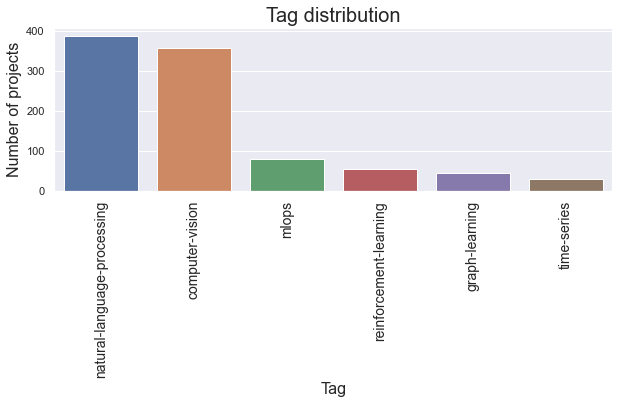

In [12]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [13]:
# Wordcloud representation
def display_word_cloud(tag:"natural-language-processing"):
    plt.figure(figsize=(15,5))
    subset = df[df.tag == tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

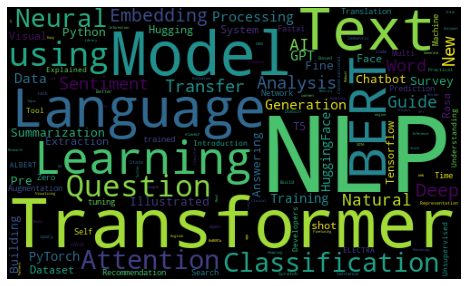

In [14]:
display_word_cloud("natural-language-processing")

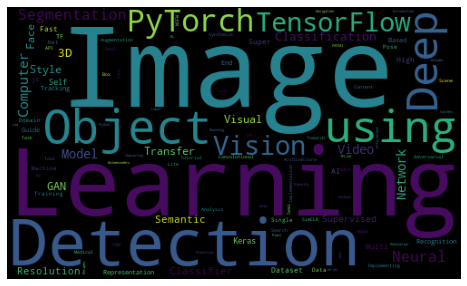

In [15]:
display_word_cloud("computer-vision")

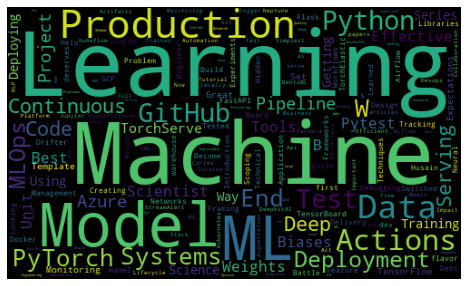

In [16]:
display_word_cloud("mlops")

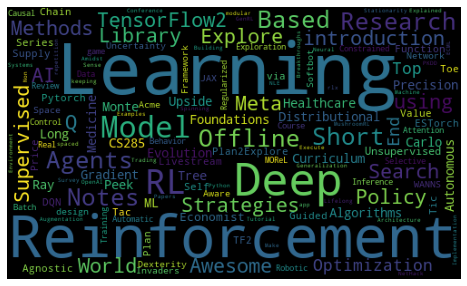

In [17]:
display_word_cloud("reinforcement-learning")

# Labelling

In [18]:
# Min frequency
min_freq = 75
tags = Counter(df.tag.values)

In [19]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [20]:
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)

In [21]:
# Fill None with other
df.tag = df.tag.fillna("other")

In [22]:
# Now we have tags with values Computer Vision, NLP, mlops, others
df.head(10)

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other
5,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
6,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other
7,27,2020-03-07 23:18:15,APPNP and PPNP,"A PyTorch implementation of ""Predict then Prop...",other
8,28,2020-03-07 23:23:46,Attributed Social Network Embedding,A sparsity aware and memory efficient implemen...,other
9,29,2020-03-07 23:45:38,Signed Graph Convolutional Network,"A PyTorch implementation of ""Signed Graph Conv...",other


# Preprocessing

In [23]:
# Feature Engineering
df["text"] = df.title + " " + df.description 

In [24]:
df.head(5)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...


In [25]:
! pip install nltk==3.7 -q

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [27]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [29]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [30]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


# Encoding

In [31]:
import numpy as np
import random

In [32]:
# Get data
X = df.text.to_numpy()
y = df.tag

In [33]:
class LabelEncoder(object):
    """Encode labels into unique indices."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [35]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [36]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [37]:
# Tesing the encoded domain
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [38]:
# Tesing the decoded domain
label_encoder.decode([0, 1, 2])

['computer-vision', 'mlops', 'natural-language-processing']

In [39]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [40]:
X

array(['comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes',
       'show infer tell contextual inference creative captioning beauty work lies way architects fundamental idea humans look overall image individual pieces',
       'awesome graph classification collection important graph embedding classification representation learning papers implementations',
       'awesome monte carlo tree search curated list monte carlo tree search papers implementations',
       'diffusion vector reference implementation diffusion2vec complenet 2018 built gensim networkx',
       'attentionwalk pytorch implementation watch step learning node embeddings via graph attention neurips 2018',
       'graph wavelet neural network pytorch implementation graph wavelet neural network iclr 2019',
       'appnp ppnp pytorch implementation predict propagate graph neural networks meet personalized pagerank iclr 2019',
       'attributed social netwo

In [41]:
y

array([0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3,
       2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 3, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2,
       0, 3, 2, 0, 2, 0, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 3, 2, 3, 3, 0, 2, 0, 0, 3, 3, 2, 2,
       2, 2, 2, 3, 0, 2, 0, 0, 0, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 3,
       3, 3, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 3, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 3, 0, 3, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2,
       0, 2, 0, 1, 2, 3, 1, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 0, 2, 2, 2, 3,
       3, 3, 2, 0, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 3, 3, 2, 2, 2, 3,
       0, 3, 2, 2, 2, 0, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 2, 0, 0, 3, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0,

# Splitting the dataset into Train, Val and Test 

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [44]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [45]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [46]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [47]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [48]:

# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [49]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [50]:
X_train

array(['limitations deep learning vision might fix opinion paper strengths weaknesses deep nets vision',
       'unsupervised reinforcement learning lecture unsupervised reinforcement learning sergey levine originally prepared aamas 2020',
       'explainable ml monitoring video covers overview risks ai need explainable monitoring exactly mean talk',
       'transfer learning fine tuning keras 100 date guide transfer learning fine tuning keras',
       'tensorboard dev easily host track share ml experiments free',
       'prophet forecasting scale tool producing high quality forecasts time series data multiple seasonality linear non linear growth',
       'interactive analysis sentence embeddings learn interactively explore sentence embedding labels tensorflow embedding projector',
       'unet implementation keras gpu vector map generation aerial imagery using deep learning geospatial unet',
       'contextualized topic models python package run contextualized topic modeling',
       

In [51]:
y_train

array([0, 3, 1, 0, 1, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2,
       2, 3, 0, 2, 0, 0, 2, 0, 3, 2, 0, 0, 2, 0, 1, 0, 0, 0, 3, 3, 2, 3,
       0, 3, 0, 0, 0, 2, 0, 3, 3, 3, 0, 3, 0, 0, 3, 0, 2, 2, 1, 3, 0, 2,
       3, 3, 0, 2, 3, 3, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 3, 0,
       2, 0, 0, 0, 3, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2, 2, 0, 0, 0, 2, 3, 0,
       2, 0, 2, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0,
       0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 3, 0, 0, 2, 3, 3, 0,
       2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       0, 2, 3, 3, 0, 0, 0, 0, 2, 2, 3, 2, 2, 2, 0, 0, 3, 3, 1, 0, 0, 0,
       0, 2, 0, 1, 3, 0, 0, 0, 0, 3, 0, 2, 0, 3, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0,
       0, 1, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 2, 3, 0, 2, 0, 2, 0, 1, 0, 0, 0, 3, 1,

In [52]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,limitations deep learning vision might fix opi...,computer-vision
1,unsupervised reinforcement learning lecture un...,other
2,explainable ml monitoring video covers overvie...,mlops
3,transfer learning fine tuning keras 100 date g...,computer-vision
4,tensorboard dev easily host track share ml exp...,mlops


In [53]:
test_df.head()

,text,tag
0,synthesizer rethinking self attention transfor...,natural-language-processing
1,guide natural language processing allennlp bas...,natural-language-processing
2,plan2explore plan explore via self supervised ...,other
3,w b weights biases track model training scale,mlops
4,rxnmapper unsupervised attention guided atom m...,natural-language-processing


In [54]:
val_df.head()

,text,tag
0,monitoring machine learning models production ...,mlops
1,fake new detection pytorch fake news detection...,natural-language-processing
2,machine learning fastai fastai library based r...,computer-vision
3,fast nst videos person segmentation create nst...,computer-vision
4,nlp course extension ml natural language proce...,natural-language-processing


# Augmentation

In [55]:
! pip install nlpaug==1.1.0 transformers==3.0.2 -q
! pip install snorkel==0.9.8 -q

In [56]:
import nlpaug.augmenter.word as naw

In [57]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [58]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(substitution.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
visual image generation requires variational algorithms called gans.
implementing binary generation using variational representations like gans.
conditional image compression allows random autoencoders and markers.
conditional template synthesis allows variational autoencoders like gans.
conditional risk generation using functional analyses and comparisons.
rapid image generation utilizing adobe autoencoders and printers.
digital image generation uses variational autoencoders motion sensors.
facilitates image generation using variational formats or displays.
conditional image capture using modulation approaches employing gans.
conditional method generation provides variational autoencoders input interfaces.


In [59]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(insertion.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
conditional image information generation using integer variational element autoencoders and graphics gans.
conditional on image element generation using dynamic variational autoencoders and random gans.
outputs conditional on image generation processes using multiple variational autoencoders and gans.
conditional image template generation using local variational hierarchical autoencoders tables and gans.
the conditional image model generation generates using cyclic variational autoencoders and gans.
conditional automatic image generation using standard variational protocol autoencoders and xml gans.
conditional image generation using numerical variational optimization autoencoders algorithms and input gans.
conditional pixel image generation using additive variational binary autoencoders and pixel gans.
conditional beam image content generation using variational auto

We can use aliases to transform the text, using snorkel's transformation function.

In [60]:
def replace_dash(x):
    return x.replace("-", " ")

In [61]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [62]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [63]:
print(flattened_aliases)

{'computer vision': ['cv', 'vision'], 'cv': ['vision', 'computer vision'], 'vision': ['cv', 'computer vision'], 'mlops': ['production'], 'production': ['mlops'], 'natural language processing': ['nlp', 'nlproc'], 'nlp': ['nlproc', 'natural language processing'], 'nlproc': ['nlp', 'natural language processing']}


In [64]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [65]:
from snorkel.augmentation import transformation_function

In [66]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [67]:
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning natural language processing tasks
survey reinforcement learning natural language processing tasks
survey reinforcement learning nlproc tasks


In [68]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate computer vision apply jobs using nlp
autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using nlproc


In [69]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [70]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:02<00:00, 246.70it/s]


,text,tag
0,limitations deep learning vision might fix opi...,computer-vision
0,limitations deep learning cv might fix opinion...,computer-vision
0,limitations deep learning computer vision migh...,computer-vision
1,unsupervised reinforcement learning lecture un...,other
2,explainable ml monitoring video covers overvie...,mlops


In [71]:

len(train_df), len(train_df_augmented)

(668, 901)

# Modeling

We will start with a very basic model and then we will try to enhance the model for our use case

In [72]:
import random
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)

In [73]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [74]:
def preprocess(df, lower, stem, min_freq):
    df["text"] = df.title  + " " + df.description
    df.text = df.text.apply(clean_text, lower=lower,stem=stem)

    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    print(oos_tags)
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.tag.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df




In [75]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Baseline Model

In [76]:
from sklearn.metrics import precision_recall_fscore_support

In [77]:
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True,stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [78]:
X_train

array(['laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections',
       'extract stock sentiment news headlines project generate investing insight applying sentiment analysis financial news headlines finviz',
       'big bad nlp database collection 400 nlp datasets papers included',
       'job classification job classification done using techniques nlp ml dataset used kaggle indeeed job posting',
       'optimizing mobiledet mobile deployments learn criticalities effectively optimizing mobiledet object detectors mobile deployments',
       'multimodal meme classification uniter given state art results various image text related problems project aims finetuning uniter solve hateful memes challenge',
       'gans computer vision article review series article series review important research papers gans 2015 today 6 articles 20 papers 20000 words',
       'almost everything

In [79]:
y_train

array([0, 2, 2, 2, 0, 0, 0, 3, 1, 2, 2, 2, 2, 3, 2, 0, 0, 1, 2, 3, 0, 3,
       0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 3, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 0, 3, 2, 2, 0, 2,
       0, 2, 1, 2, 3, 2, 0, 0, 2, 2, 2, 3, 0, 0, 2, 3, 0, 1, 1, 2, 1, 1,
       2, 2, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 3, 0, 2, 3,
       3, 0, 0, 2, 2, 2, 2, 0, 2, 3, 3, 2, 1, 3, 3, 0, 2, 2, 0, 0, 0, 2,
       0, 1, 0, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 0, 3,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 3, 3, 2, 0, 2, 0, 2, 3, 2, 1, 0, 0, 0, 0, 2, 0, 2,
       2, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 3, 2, 2, 2, 0, 3, 2, 3, 0, 2, 2, 2,
       2, 0, 2, 3, 0, 3, 2, 2, 3, 2, 0, 2, 0, 0, 0, 2, 3, 2, 0, 1, 2, 2,
       2, 0, 0, 0, 2, 1, 0, 1, 1, 3, 3, 2, 3, 2, 0, 0, 3, 0, 1, 3, 2, 0,
       0, 3, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2,

In [80]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [81]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred)

(144,)
[2 2 1 3 3 3 3 3 1 2 2 1 3 1 2 0 1 3 2 2 2 2 3 0 2 1 0 2 0 1 2 1 3 2 2 2 2
 3 2 0 2 3 2 0 3 3 0 0 0 0 0 3 3 2 2 1 2 2 0 0 2 1 0 2 2 3 1 3 1 0 1 2 2 1
 1 1 3 1 0 3 3 1 0 3 2 3 1 0 1 2 2 2 1 3 1 0 3 2 1 2 2 0 3 0 0 0 2 0 0 3 3
 0 3 3 0 2 0 3 2 1 2 3 2 0 1 1 1 3 3 1 2 1 2 2 3 2 1 3 0 0 3 1 0 0]


In [82]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2844744487889649,
  "recall": 0.22916666666666666,
  "f1": 0.24552884283001275
}


In [83]:
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
print(p)

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]


# Rule based predictions

In [84]:

# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


# Vectorization

In [85]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
dataset = [
    "I enjoy reading about Machine Learning and Machine Learning is my PhD subject",
    "I would enjoy a walk in the park",
    "I was reading in the library"
]

In [86]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df)

            TF-IDF
machine   0.513720
learning  0.513720
about     0.256860
subject   0.256860
phd       0.256860
and       0.256860
my        0.256860
is        0.256860
reading   0.195349
enjoy     0.195349
library   0.000000
park      0.000000
in        0.000000
the       0.000000
walk      0.000000
was       0.000000
would     0.000000


In [87]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [88]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [89]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train[0])
print (X_train.shape)  # scipy.sparse.csr_matrix

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
  (0, 27075)	0.03486417410747293
  (0, 59397)	0.037070483947105486
  (0, 61797)	0.037070483947105486
  (0, 66741)	0.037070483947105486
  (0, 20170)	0.037070483947105486
  (0, 1777)	0.037070483947105486
  (0, 69944)	0.037070483947105486
  (0, 45966)	0.037070483947105486
  (0, 48730)	0.037070483947105486
  (0, 82999)	0.037070483947105486
  (0, 6456)	0.037070483947105486
  (0, 80656)	0.037070483947105486
  (0, 32521)	0.037070483947105486
  (0, 81967)	0.037070483947105486
  (0, 93476)	0.037070483947105486
  (0, 7558)	0.037070483947105486
  (0, 22293)	0.037070483947105486
  (0, 42253)	0.037070483947105486
  (0, 55697)	0.037070483947105486
  (0, 12496)	0.037070483947105486
  (0, 74148)	0.037070483947105486
  (0, 3948)	0.03486417410747293
  (0, 21788)	0.037070483947105486
  (0, 27441)	0.037070483947105486
  (0, 81591)	0.0370

In [90]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [249  55 272  92],
class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


# Data Imbalance

In [91]:
! pip install imbalanced-learn==0.8.1 -q

In [92]:
from imblearn.over_sampling import RandomOverSampler

In [93]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [94]:
import matplotlib.pylab as plt

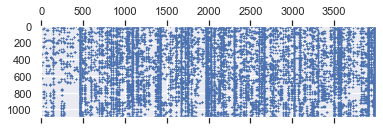

In [95]:
plt.spy(X_over[:,0:4000],markersize=0.5)

In [96]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


# Machine Learning
We are going to use SGD with log loss, which is basically logistic loss

In [97]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [98]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="optimal", eta0=1e-1, power_t=0.1, 
    warm_start=True)

In [99]:
# Train model
num_epochs = 5000
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 0.12565, val_loss: 0.39472
Epoch: 10 | train_loss: 0.12973, val_loss: 0.40077
Epoch: 20 | train_loss: 0.12325, val_loss: 0.39595
Epoch: 30 | train_loss: 0.13204, val_loss: 0.40479
Epoch: 40 | train_loss: 0.11880, val_loss: 0.38008
Epoch: 50 | train_loss: 0.13180, val_loss: 0.38998
Epoch: 60 | train_loss: 0.11787, val_loss: 0.38785
Epoch: 70 | train_loss: 0.12742, val_loss: 0.39450
Epoch: 80 | train_loss: 0.12612, val_loss: 0.39527
Epoch: 90 | train_loss: 0.12051, val_loss: 0.39132
Epoch: 100 | train_loss: 0.13434, val_loss: 0.40580
Epoch: 110 | train_loss: 0.11932, val_loss: 0.40043
Epoch: 120 | train_loss: 0.12565, val_loss: 0.39482
Epoch: 130 | train_loss: 0.11483, val_loss: 0.38106
Epoch: 140 | train_loss: 0.11669, val_loss: 0.38209
Epoch: 150 | train_loss: 0.12031, val_loss: 0.39668
Epoch: 160 | train_loss: 0.12609, val_loss: 0.39952
Epoch: 170 | train_loss: 0.12471, val_loss: 0.38859
Epoch: 180 | train_loss: 0.12086, val_loss: 0.39821
Epoch: 190 | train_los

In [100]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.874609042159669,
  "recall": 0.875,
  "f1": 0.8735469896460608
}


In [101]:

# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [102]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.02351830400423087,
 'mlops': 0.003910477619280936,
 'natural-language-processing': 0.9616269158473808,
 'other': 0.010944302529107273}

In [103]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1
threshold

0.7103890340506117

In [104]:
# Evaluate
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults 
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=label_encoder.class_to_index["other"])
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9042181069958848,
  "recall": 0.7569444444444444,
  "f1": 0.7907514466337996
}


# Evaluation
So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

Coarse-grained metrics\
Fine-grained metrics\
Confusion matrix\
Confidence learning\
Slice metrics

In [105]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [106]:
# Data to evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)

In [107]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9042181069958848,
    "recall": 0.7569444444444444,
    "f1": 0.7907514466337996,
    "num_samples": 144.0
}


In [108]:

from collections import OrderedDict

In [109]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [110]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7586206896551724,
    "f1": 0.8627450980392156,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.37037037037037035,
    "recall": 1.0,
    "f1": 0.5405405405405406,
    "num_samples": 20.0
  }
]


In [111]:
# TP, FP, FN samples
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [112]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [113]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}")

pytest pytest framework makes easy write small tests yet scales support complex functional testing
true: mlops
pred: mlops


In [114]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag="mlops"):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))

    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i, true in enumerate(y_test):
        pred = y_pred[i]
        if index==true==pred:
            tp.append(i)
        elif index!=true and index==pred:
            fp.append(i)
        elif index==true and index!=pred:
            fn.append(i)

    # Samples
    num_samples = 3
    cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
    for item in cm:
        if len(item[0]):
            print (f"\n=== {item[1]} ===")
            for index in item[0][:num_samples]:
                print (f"  {X_test_raw[index]}")
                print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
                print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")

interactive(children=(Dropdown(description='tag', index=1, options=('natural-language-processing', 'mlops', 'c…

# Confidence Learning

In [115]:
# y
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [116]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

In [117]:

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

In [118]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i], 
                               "true": label_encoder.index_to_class[y_test[i]], 
                               "pred": label_encoder.index_to_class[y_pred[i]], 
                               "prob": prob})

In [119]:
low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.36374216496858813}]

In [120]:

! pip install cleanlab==1.0.1 -q

In [121]:
import cleanlab
from cleanlab.pruning import get_noise_indices

In [122]:
# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test, 
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)

In [123]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other



In [124]:
! pip install snorkel==0.9.8 

In [125]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [126]:
@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)

In [127]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [128]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 12195.45it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [129]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 18332.97it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [130]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 6204.15it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [131]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [132]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.6,
    "recall": 0.6,
    "f1": 0.6,
    "num_samples": 5
  }
}


# Interpretabality

In [133]:

! pip install lime==0.2.0.1 -q

In [134]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [135]:
# Create pipeline
pipe = make_pipeline(vectorizer, model)

In [136]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

# Behavioral Testing

In [137]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)

In [138]:

# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [139]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']

# Experiment Tracking

In [140]:
! pip install mlflow==1.13.1 --user -q

In [141]:
from argparse import Namespace
import mlflow
from pathlib import Path

In [142]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100
)

In [143]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
print(MODEL_REGISTRY)
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file:///" + str(MODEL_REGISTRY.absolute()))


experiments


In [144]:
! pip install optuna
import optuna

In [145]:
def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seeds()
    df = pd.read_csv("labeled_projects.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
    label_encoder = LabelEncoder().fit(df.tag)
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    model = SGDClassifier(
        loss="log", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t, 
        warm_start=True)

    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

        # Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning (for optimization in next section)
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Threshold
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    args.threshold = np.quantile(
        [y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1

    # Evaluation
    other_index = label_encoder.class_to_index["other"]
    y_prob = model.predict_proba(X_test)
    y_pred = custom_predict(y_prob=y_prob, threshold=args.threshold, index=other_index)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "args": args,
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [146]:
import joblib
import tempfile

In [147]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

In [148]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [149]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.16783, val_loss: 1.20177
Epoch: 10 | train_loss: 0.46262, val_loss: 0.62612
Epoch: 20 | train_loss: 0.31599, val_loss: 0.51986
Epoch: 30 | train_loss: 0.25191, val_loss: 0.47544
Epoch: 40 | train_loss: 0.21720, val_loss: 0.45176
Epoch: 50 | train_loss: 0.19610, val_loss: 0.43770
Epoch: 60 | train_loss: 0.18221, val_loss: 0.42857
Epoch: 70 | train_loss: 0.17291, val_loss: 0.42246
Epoch: 80 | train_loss: 0.16643, val_loss: 0.41818
Epoch: 90 | train_loss: 0.16160, val_loss: 0.41528
{
  "precision": 0.9116161616161617,
  "recall": 0.7569444444444444,
  "f1": 0.7929971988795519
}


In [150]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [151]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  c72624d4383f4c03abd2e9e0b7ebf254             0  FINISHED   
1  12afb9de8e724c8195937ee75c58c31b             0  FINISHED   

                                        artifact_uri  \
0  file:///c:\D_drive\Practise\MLops\experiments/...   
1  file:///c:\D_drive\Practise\MLops\experiments/...   

                        start_time                         end_time  \
0 2022-08-27 08:48:38.526000+00:00 2022-08-27 08:48:48.865000+00:00   
1 2022-08-26 02:56:38.392000+00:00 2022-08-26 02:56:45.582000+00:00   

   metrics.recall  metrics.val_loss  metrics.train_loss  metrics.f1  ...  \
0        0.756944          0.413484            0.158647    0.792997  ...   
1        0.756944          0.413484            0.158647    0.792997  ...   

   params.lower params.ngram_max_range params.learning_rate params.power_t  \
0          True                      7                  0.1            0.1   
1          True                      7    

In [152]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

In [153]:
print (json.dumps(performance, indent=2))

{
  "precision": 0.9116161616161617,
  "recall": 0.7569444444444444,
  "f1": 0.7929971988795519
}


In [154]:
# Inference
text = "Transfer learning with transformers for video  classification."
predict_tag(texts=[text])

['natural-language-processing']

# Optimization

In [155]:
! pip install optuna==2.10.0 numpyencoder==0.3.0 -q

In [156]:
import optuna

In [157]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    args.analyzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
    args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
    args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
    args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)

    # Train & evaluate
    artifacts = train(args=args, df=df, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

In [158]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [159]:
NUM_TRIALS = 20  # small sample for now

In [160]:
# Optimize
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
            n_trials=NUM_TRIALS,
            callbacks=[mlflow_callback])

[I 2022-08-27 10:48:57,082] A new study created in memory with name: optimization


['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.99665, val_loss: 1.05201
Epoch: 10 | train_loss: 0.34176, val_loss: 0.51364
Epoch: 20 | train_loss: 0.23825, val_loss: 0.44056
Epoch: 30 | train_loss: 0.19663, val_loss: 0.41264
Epoch: 40 | train_loss: 0.17593, val_loss: 0.39920
Epoch: 50 | train_loss: 0.16395, val_loss: 0.39201
Epoch: 60 | train_loss: 0.15613, val_loss: 0.38771
Epoch: 70 | train_loss: 0.15139, val_loss: 0.38458
Epoch: 80 | train_loss: 0.14842, val_loss: 0.38254
Epoch: 90 | train_loss: 0.14594, val_loss: 0.38174


[I 2022-08-27 10:49:00,263] Trial 0 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 5, 'learning_rate': 0.14223456058874986, 'power_t': 0.49992951336477687}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.80570, val_loss: 1.05311
Epoch: 10 | train_loss: 0.23640, val_loss: 0.73292
Epoch: 20 | train_loss: 0.21212, val_loss: 0.71622
Epoch: 30 | train_loss: 0.20866, val_loss: 0.71219
Epoch: 40 | train_loss: 0.20750, val_loss: 0.71113
Epoch: 50 | train_loss: 0.20707, val_loss: 0.71070
Epoch: 60 | train_loss: 0.20677, val_loss: 0.71017
Epoch: 70 | train_loss: 0.20689, val_loss: 0.71016
Epoch: 80 | train_loss: 0.20689, val_loss: 0.70998
Epoch: 90 | train_loss: 0.20620, val_loss: 0.70988
{
  "precision": 0.8053489064127362,
  "recall": 0.7013888888888888,
  "f1": 0.7292118737995944
}

[I 2022-08-27 10:49:03,038] Trial 1 finished with value: 0.7292118737995944 and parameters: {'analyzer': 'word', 'ngram_max_range': 7, 'learning_rate': 0.8488625987860094, 'power_t': 0.3854759683557406}. Best is trial 0 with value: 0.8265063522446623.



{
  "precision": 0.8053489064127362,
  "recall": 0.7013888888888888,
  "f1": 0.7292118737995944
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.25566, val_loss: 1.29705
Epoch: 10 | train_loss: 0.56681, val_loss: 0.89437
Epoch: 20 | train_loss: 0.38355, val_loss: 0.79378
Epoch: 30 | train_loss: 0.30728, val_loss: 0.75143
Epoch: 40 | train_loss: 0.26800, val_loss: 0.72911
Epoch: 50 | train_loss: 0.24545, val_loss: 0.71588
Epoch: 60 | train_loss: 0.23157, val_loss: 0.70743
Epoch: 70 | train_loss: 0.22273, val_loss: 0.70178
Epoch: 80 | train_loss: 0.21687, val_loss: 0.69785
Epoch: 90 | train_loss: 0.21282, val_loss: 0.69503


[I 2022-08-27 10:49:05,363] Trial 2 finished with value: 0.7254175826656525 and parameters: {'analyzer': 'word', 'ngram_max_range': 4, 'learning_rate': 0.15535214329644056, 'power_t': 0.18400736273364726}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.795198147485115,
  "recall": 0.7013888888888888,
  "f1": 0.7254175826656525
}
{
  "precision": 0.795198147485115,
  "recall": 0.7013888888888888,
  "f1": 0.7254175826656525
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.31331, val_loss: 1.32593
Epoch: 10 | train_loss: 0.79444, val_loss: 0.89067
Epoch: 20 | train_loss: 0.58902, val_loss: 0.72382
Epoch: 30 | train_loss: 0.47894, val_loss: 0.63810
Epoch: 40 | train_loss: 0.40895, val_loss: 0.58534
Epoch: 50 | train_loss: 0.36012, val_loss: 0.54952
Epoch: 60 | train_loss: 0.32391, val_loss: 0.52345
Epoch: 70 | train_loss: 0.29617, val_loss: 0.50375
Epoch: 80 | train_loss: 0.27430, val_loss: 0.48837
Epoch: 90 | train_loss: 0.25658, val_loss: 0.47609


[I 2022-08-27 10:49:11,269] Trial 3 finished with value: 0.7962270665156688 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.031661780082822756, 'power_t': 0.3882127606370601}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.905188679245283,
  "recall": 0.7638888888888888,
  "f1": 0.7962270665156688
}
{
  "precision": 0.905188679245283,
  "recall": 0.7638888888888888,
  "f1": 0.7962270665156688
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.08524, val_loss: 1.21057
Epoch: 10 | train_loss: 0.33831, val_loss: 0.79372
Epoch: 20 | train_loss: 0.25071, val_loss: 0.74228
Epoch: 30 | train_loss: 0.22595, val_loss: 0.72606
Epoch: 40 | train_loss: 0.21697, val_loss: 0.71956
Epoch: 50 | train_loss: 0.21325, val_loss: 0.71646
Epoch: 60 | train_loss: 0.21139, val_loss: 0.71465
Epoch: 70 | train_loss: 0.21055, val_loss: 0.71360
Epoch: 80 | train_loss: 0.21003, val_loss: 0.71287
Epoch: 90 | train_loss: 0.20949, val_loss: 0.71238


[I 2022-08-27 10:49:14,098] Trial 4 finished with value: 0.7292118737995944 and parameters: {'analyzer': 'word', 'ngram_max_range': 7, 'learning_rate': 0.38636536807887895, 'power_t': 0.10400465688019095}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.8053489064127362,
  "recall": 0.7013888888888888,
  "f1": 0.7292118737995944
}
{
  "precision": 0.8053489064127362,
  "recall": 0.7013888888888888,
  "f1": 0.7292118737995944
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.37601, val_loss: 1.38039
Epoch: 10 | train_loss: 1.26553, val_loss: 1.31674
Epoch: 20 | train_loss: 1.15723, val_loss: 1.25512
Epoch: 30 | train_loss: 1.05978, val_loss: 1.20051
Epoch: 40 | train_loss: 0.97437, val_loss: 1.15312
Epoch: 50 | train_loss: 0.90011, val_loss: 1.11212
Epoch: 60 | train_loss: 0.83562, val_loss: 1.07658
Epoch: 70 | train_loss: 0.77952, val_loss: 1.04566
Epoch: 80 | train_loss: 0.73055, val_loss: 1.01864
Epoch: 90 | train_loss: 0.68763, val_loss: 0.99493


[I 2022-08-27 10:49:17,153] Trial 5 finished with value: 0.7094650104560591 and parameters: {'analyzer': 'word', 'ngram_max_range': 8, 'learning_rate': 0.014528120814125635, 'power_t': 0.2914386642732475}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.7948888952178426,
  "recall": 0.6805555555555556,
  "f1": 0.7094650104560591
}
{
  "precision": 0.7948888952178426,
  "recall": 0.6805555555555556,
  "f1": 0.7094650104560591
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.35675, val_loss: 1.36149
Epoch: 10 | train_loss: 1.06140, val_loss: 1.10844
Epoch: 20 | train_loss: 0.87096, val_loss: 0.94502
Epoch: 30 | train_loss: 0.74803, val_loss: 0.84072
Epoch: 40 | train_loss: 0.66209, val_loss: 0.76909
Epoch: 50 | train_loss: 0.59795, val_loss: 0.71664
Epoch: 60 | train_loss: 0.54767, val_loss: 0.67625
Epoch: 70 | train_loss: 0.50701, val_loss: 0.64412
Epoch: 80 | train_loss: 0.47328, val_loss: 0.61787
Epoch: 90 | train_loss: 0.44471, val_loss: 0.59596


[I 2022-08-27 10:49:22,194] Trial 6 finished with value: 0.7937671869193609 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 7, 'learning_rate': 0.011217487666408224, 'power_t': 0.4855084025232246}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.888894339787197,
  "recall": 0.7638888888888888,
  "f1": 0.7937671869193609
}
{
  "precision": 0.888894339787197,
  "recall": 0.7638888888888888,
  "f1": 0.7937671869193609
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.06525, val_loss: 1.11200
Epoch: 10 | train_loss: 0.35547, val_loss: 0.54902
Epoch: 20 | train_loss: 0.24314, val_loss: 0.47201
Epoch: 30 | train_loss: 0.20025, val_loss: 0.44337
Epoch: 40 | train_loss: 0.17961, val_loss: 0.42976
Epoch: 50 | train_loss: 0.16829, val_loss: 0.42269
Epoch: 60 | train_loss: 0.16134, val_loss: 0.41862
Epoch: 70 | train_loss: 0.15717, val_loss: 0.41615
Epoch: 80 | train_loss: 0.15447, val_loss: 0.41450
Epoch: 90 | train_loss: 0.15237, val_loss: 0.41371


[I 2022-08-27 10:49:31,654] Trial 7 finished with value: 0.7872606352482514 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.16383377924256345, 'power_t': 0.20923280024754454}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9107142857142857,
  "recall": 0.75,
  "f1": 0.7872606352482514
}
{
  "precision": 0.9107142857142857,
  "recall": 0.75,
  "f1": 0.7872606352482514
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.66970, val_loss: 0.77985


[I 2022-08-27 10:49:35,309] Trial 8 pruned. 


['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.36100, val_loss: 1.37211
Epoch: 10 | train_loss: 1.10097, val_loss: 1.22645
Epoch: 20 | train_loss: 0.90132, val_loss: 1.11668
Epoch: 30 | train_loss: 0.75898, val_loss: 1.03855
Epoch: 40 | train_loss: 0.65621, val_loss: 0.98189
Epoch: 50 | train_loss: 0.57998, val_loss: 0.93963
Epoch: 60 | train_loss: 0.52178, val_loss: 0.90719
Epoch: 70 | train_loss: 0.47622, val_loss: 0.88167
Epoch: 80 | train_loss: 0.43977, val_loss: 0.86113
Epoch: 90 | train_loss: 0.41006, val_loss: 0.84432


[I 2022-08-27 10:49:38,401] Trial 9 finished with value: 0.7222058905225732 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.035312759402365175, 'power_t': 0.25019884014912047}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.7993251737470054,
  "recall": 0.6944444444444444,
  "f1": 0.7222058905225732
}
{
  "precision": 0.7993251737470054,
  "recall": 0.6944444444444444,
  "f1": 0.7222058905225732
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.15240, val_loss: 1.18565
Epoch: 10 | train_loss: 0.50767, val_loss: 0.64023
Epoch: 20 | train_loss: 0.36653, val_loss: 0.53520
Epoch: 30 | train_loss: 0.29952, val_loss: 0.48976
Epoch: 40 | train_loss: 0.26054, val_loss: 0.46478
Epoch: 50 | train_loss: 0.23466, val_loss: 0.44933
Epoch: 60 | train_loss: 0.21592, val_loss: 0.43900
Epoch: 70 | train_loss: 0.20261, val_loss: 0.43117
Epoch: 80 | train_loss: 0.19286, val_loss: 0.42565
Epoch: 90 | train_loss: 0.18493, val_loss: 0.42205

[I 2022-08-27 10:49:41,217] Trial 10 finished with value: 0.7958645411885326 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 3, 'learning_rate': 0.06916884785593319, 'power_t': 0.4994850176718927}. Best is trial 0 with value: 0.8265063522446623.



{
  "precision": 0.8963276556413811,
  "recall": 0.7638888888888888,
  "f1": 0.7958645411885326
}
{
  "precision": 0.8963276556413811,
  "recall": 0.7638888888888888,
  "f1": 0.7958645411885326
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.29102, val_loss: 1.30775
Epoch: 10 | train_loss: 0.71676, val_loss: 0.82770
Epoch: 20 | train_loss: 0.52374, val_loss: 0.67204
Epoch: 30 | train_loss: 0.42371, val_loss: 0.59480
Epoch: 40 | train_loss: 0.36132, val_loss: 0.54814
Epoch: 50 | train_loss: 0.31838, val_loss: 0.51696
Epoch: 60 | train_loss: 0.28684, val_loss: 0.49448
Epoch: 70 | train_loss: 0.26299, val_loss: 0.47770
Epoch: 80 | train_loss: 0.24440, val_loss: 0.46473
Epoch: 90 | train_loss: 0.22943, val_loss: 0.45451


[I 2022-08-27 10:49:46,257] Trial 11 finished with value: 0.7839703671014351 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.03720468956096613, 'power_t': 0.4000766302576916}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7839703671014351
}
{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7839703671014351
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.19489, val_loss: 1.22312
Epoch: 10 | train_loss: 0.52954, val_loss: 0.65778
Epoch: 20 | train_loss: 0.37546, val_loss: 0.53801
Epoch: 30 | train_loss: 0.30195, val_loss: 0.48440
Epoch: 40 | train_loss: 0.25887, val_loss: 0.45413
Epoch: 50 | train_loss: 0.23058, val_loss: 0.43508
Epoch: 60 | train_loss: 0.21056, val_loss: 0.42191
Epoch: 70 | train_loss: 0.19616, val_loss: 0.41242
Epoch: 80 | train_loss: 0.18549, val_loss: 0.40543
Epoch: 90 | train_loss: 0.17710, val_loss: 0.40032


[I 2022-08-27 10:49:50,392] Trial 12 finished with value: 0.8152028983014898 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 5, 'learning_rate': 0.0630223281623813, 'power_t': 0.4023460827472991}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9155773420479303,
  "recall": 0.7847222222222222,
  "f1": 0.8152028983014898
}
{
  "precision": 0.9155773420479303,
  "recall": 0.7847222222222222,
  "f1": 0.8152028983014898
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.06605, val_loss: 1.11200
Epoch: 10 | train_loss: 0.39232, val_loss: 0.55098
Epoch: 20 | train_loss: 0.27284, val_loss: 0.46416
Epoch: 30 | train_loss: 0.22166, val_loss: 0.42911
Epoch: 40 | train_loss: 0.19453, val_loss: 0.41110
Epoch: 50 | train_loss: 0.17806, val_loss: 0.40081
Epoch: 60 | train_loss: 0.16708, val_loss: 0.39424
Epoch: 70 | train_loss: 0.15992, val_loss: 0.38963
Epoch: 80 | train_loss: 0.15511, val_loss: 0.38650
Epoch: 90 | train_loss: 0.15137, val_loss: 0.38474


[I 2022-08-27 10:49:54,457] Trial 13 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 5, 'learning_rate': 0.11109446415088275, 'power_t': 0.43882017775643656}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
['time-series', 'reinforcement-learning']


[I 2022-08-27 10:49:55,305] Trial 14 pruned. 


Epoch: 00 | train_loss: 0.78375, val_loss: 0.86647
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.04552, val_loss: 1.09426
Epoch: 10 | train_loss: 0.37620, val_loss: 0.53894
Epoch: 20 | train_loss: 0.26158, val_loss: 0.45640
Epoch: 30 | train_loss: 0.21336, val_loss: 0.42361
Epoch: 40 | train_loss: 0.18826, val_loss: 0.40706
Epoch: 50 | train_loss: 0.17322, val_loss: 0.39776
Epoch: 60 | train_loss: 0.16327, val_loss: 0.39193
Epoch: 70 | train_loss: 0.15692, val_loss: 0.38782
Epoch: 80 | train_loss: 0.15272, val_loss: 0.38507
Epoch: 90 | train_loss: 0.14942, val_loss: 0.38364


[I 2022-08-27 10:49:59,335] Trial 15 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 5, 'learning_rate': 0.1198340218536453, 'power_t': 0.34924231303008335}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.78742, val_loss: 0.87084
Epoch: 10 | train_loss: 0.24119, val_loss: 0.44434
Epoch: 20 | train_loss: 0.17872, val_loss: 0.40397
Epoch: 30 | train_loss: 0.15885, val_loss: 0.39141
Epoch: 40 | train_loss: 0.15137, val_loss: 0.38715
Epoch: 50 | train_loss: 0.14780, val_loss: 0.38551
Epoch: 60 | train_loss: 0.14444, val_loss: 0.38526
Epoch: 70 | train_loss: 0.14349, val_loss: 0.38353
Epoch: 80 | train_loss: 0.14301, val_loss: 0.38233
Epoch: 90 | train_loss: 0.14152, val_loss: 0.38317


[I 2022-08-27 10:50:02,828] Trial 16 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 4, 'learning_rate': 0.26818531032472864, 'power_t': 0.44843900337861003}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 1.15275, val_loss: 1.18684
Epoch: 10 | train_loss: 0.47216, val_loss: 0.61478
Epoch: 20 | train_loss: 0.33030, val_loss: 0.50809
Epoch: 30 | train_loss: 0.26531, val_loss: 0.46210
Epoch: 40 | train_loss: 0.22858, val_loss: 0.43693
Epoch: 50 | train_loss: 0.20524, val_loss: 0.42160
Epoch: 60 | train_loss: 0.18919, val_loss: 0.41126
Epoch: 70 | train_loss: 0.17803, val_loss: 0.40398
Epoch: 80 | train_loss: 0.17001, val_loss: 0.39874
Epoch: 90 | train_loss: 0.16384, val_loss: 0.39510


[I 2022-08-27 10:50:07,335] Trial 17 finished with value: 0.8157618602734953 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.08068966590467225, 'power_t': 0.3268908033372545}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9155773420479303,
  "recall": 0.7847222222222222,
  "f1": 0.8157618602734953
}
{
  "precision": 0.9155773420479303,
  "recall": 0.7847222222222222,
  "f1": 0.8157618602734953
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.95084, val_loss: 1.01195
Epoch: 10 | train_loss: 0.32140, val_loss: 0.49888
Epoch: 20 | train_loss: 0.22639, val_loss: 0.43366
Epoch: 30 | train_loss: 0.18926, val_loss: 0.40967
Epoch: 40 | train_loss: 0.17144, val_loss: 0.39868
Epoch: 50 | train_loss: 0.16125, val_loss: 0.39299
Epoch: 60 | train_loss: 0.15447, val_loss: 0.38993
Epoch: 70 | train_loss: 0.15061, val_loss: 0.38724
Epoch: 80 | train_loss: 0.14834, val_loss: 0.38559
Epoch: 90 | train_loss: 0.14616, val_loss: 0.38536


[I 2022-08-27 10:50:10,828] Trial 18 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 4, 'learning_rate': 0.15865146722733248, 'power_t': 0.3260848899083696}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
['time-series', 'reinforcement-learning']
Epoch: 00 | train_loss: 0.76450, val_loss: 0.85121
Epoch: 10 | train_loss: 0.23212, val_loss: 0.43845
Epoch: 20 | train_loss: 0.17399, val_loss: 0.40118
Epoch: 30 | train_loss: 0.15618, val_loss: 0.38987
Epoch: 40 | train_loss: 0.14977, val_loss: 0.38627
Epoch: 50 | train_loss: 0.14686, val_loss: 0.38499
Epoch: 60 | train_loss: 0.14367, val_loss: 0.38496
Epoch: 70 | train_loss: 0.14297, val_loss: 0.38323
Epoch: 80 | train_loss: 0.14259, val_loss: 0.38198
Epoch: 90 | train_loss: 0.14109, val_loss: 0.38293


[I 2022-08-27 10:50:14,272] Trial 19 finished with value: 0.8265063522446623 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 4, 'learning_rate': 0.2885274330895245, 'power_t': 0.45311646703871344}. Best is trial 0 with value: 0.8265063522446623.


{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}
{
  "precision": 0.9178004535147392,
  "recall": 0.7986111111111112,
  "f1": 0.8265063522446623
}


In [161]:
# Now we will work on packaging